In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint

train = list()
test = list()

for i in range(10):
    train.append(np.array(pd.read_csv('Part3_%d_Train.csv'%i, header=None)))
    test.append(np.array(pd.read_csv('Part3_%d_Test.csv'%i, header=None)))

np.random.seed(21)
X_train = np.vstack(train)
y_train = np.concatenate([np.tile(i, train[i].shape[0]) for i in range(10)])
idx_train = np.array(range(X_train.shape[0]))
np.random.shuffle(idx_train)
X_train = X_train[idx_train][:200]
y_train = y_train[idx_train][:200]

X_test = np.vstack(test)
y_test = np.concatenate([np.tile(i, test[i].shape[0]) for i in range(10)])
idx_test = np.array(range(X_test.shape[0]))
np.random.shuffle(idx_test)
X_test = X_test[idx_test][:50]
y_test = y_test[idx_test][:50]

enc = np.eye(10)
def one_hot(d):
    return enc[d]

print(X_train.shape, X_test.shape)
# print(y_test)

(200, 784) (50, 784)


In [6]:
from skimage.util import view_as_windows, view_as_blocks
W_conv = np.zeros((16, (7+21)*7+1))
W_out = np.empty((10, 22*22*16+1))

class seeded_session:
    def __enter__(self):
        np.random.seed(25523)
        global W_conv, W_out
        padded_weights = W_conv[:, :-1].reshape((-1, 7, 28))
        padded_weights[:, :, :7] = np.random.rand(16, 7, 7)*1e-4
        padded_weights[:, :, 7:] = 0#np.random.rand(16, 7, 1)*1e-4
        W_conv[:, -1:] = np.random.rand(16, 1)*1e-5
        W_out[:] = np.random.rand(*W_out.shape)
        return W_conv, W_out
    def __exit__(self, type, value, traceback):
        pass

with seeded_session():
    print(W_conv.shape, W_out.shape)

(16, 197) (10, 7745)


# Forward pass

In [ ]:
from scipy.signal import convolve2d
A = np.arange(9).reshape(3,3)
B = np.ones((2,2))
print(A)
print(B)
convolve2d(A,B,mode='valid')

[ 0.08286333  0.06527992  0.06700819  0.12758393  0.10672698  0.10791879
  0.13492798  0.1316972   0.06665001  0.10934368] 6
[ 0.08193422  0.06645619  0.06683819  0.12520665  0.10848462  0.10742676
  0.13506241  0.13072481  0.06672083  0.11114532] 0
[ 0.08185074  0.06583572  0.06729152  0.12790936  0.10520385  0.10992169
  0.13471538  0.13237192  0.06546616  0.10943368] 8


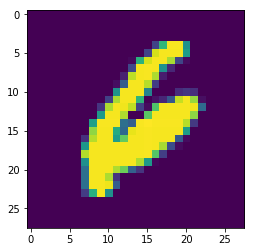

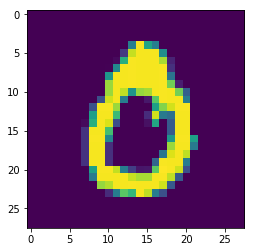

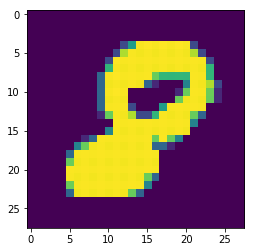

In [5]:
import itertools


def conv7(w):
    """ 7x7 convolution in matrix form """
    def forward(x):
        convmat = np.block([
            #                 vvv throw away final padding & bias
            [np.zeros(jj), w[:-22], np.zeros(21-jj)] for jj in range(22)
        ])
        rows = np.array([np.dot(convmat, x[ii*28:ii*28+7*28]) for ii in range(22)])
        return np.tanh(rows.ravel() + w[-1])
    from scipy.signal import convolve2d
    def forward0(x):
        return np.tanh(convolve2d(
            x.reshape(28, 28),
            w[:-1].reshape((7, 28))[:, :7],
            mode='valid').ravel() + w[-1])
    return forward

def softmax(x):
    a = np.exp(x)
    return a / np.sum(a)

def perceptron(w):
    return lambda x: np.dot(w[:-1], x) + w[-1]

conv_filters = [conv7(w) for w in W_conv]
conv_layer = lambda x: np.array([f(x) for f in conv_filters])
output_neurons = [perceptron(w) for w in W_out]
fc_layer = lambda x: softmax([f(x.ravel()) for f in output_neurons])
model = lambda x: fc_layer(conv_layer(x))

with seeded_session():
    for k in range(3):
        plt.figure()
        plt.imshow(X_train[k].reshape(28, 28).T)
        print(model(X_train[k]), y_train[k])

# Backward pass

Assuming loss function: $ \text{loss}(\mathbf{y}) = -\sum_j { d_j \log y_j } $

**Output layer**

$$
\delta_j^H = \frac{\partial E}{\partial \nu_j^H} = -e_j
$$

$$
\Delta w_{ij}^H = -\alpha \delta_j^H y_i^{H-1}
$$

$$
\Delta b_j^H = -\alpha \delta_j^H
$$

**Hidden layer**

$$
\delta_j^h = \frac{\partial E}{\partial \nu_j^h} = \left( \sum_{l = 1}^{L^{h+1}} \frac{\partial E}{\partial \nu_l^{h+1}} \frac{\partial \nu_l^{h+1}}{\partial y_j^h} \right) \frac{\partial y_j^h}{\partial \nu_j^h}
=\left( \sum_{l = 1}^{L^{h+1}} {\delta_l^H w_{jl}^H} \right) (1-(y_j^h)^2)
$$

$$
\Delta w_{i}^h = -\alpha \sum_{j=1}^{L^0} {\delta_j^h \frac{\partial \nu_j^h}{\partial w_i^h}}
=-\alpha \sum_{j=1}^{L^0} {\delta_j^h  {x_{j+i-1}}}
$$

$$
\Delta b^h = -\alpha \sum_{j=1}^{L^0} {\delta_j^h \frac{\partial \nu_j^h}{\partial b^h}}
=-\alpha \sum_{j=1}^{L^0} {\delta_j^h }
$$

In [ ]:
np.arange(28*28)[list(itertools.chain(*[range(i,i+7) for i in range(0, 7*28, 28)]))] #s(x)
# np. #x[?]

In [ ]:
test_image = np.arange(25).reshape(5,5)
print(test_image)
test_filter = np.ones((3,3))
np.array([test_image[i:i+2, j:j+2].ravel() for i in range(3) for j in range(3)])

In [ ]:
[ np.arange(28*28).reshape(28, 28)[i:i+22, j:j+22].ravel() for i in range(7) for j in range(7) ]

In [6]:
def train_one(x, d, alpha, verbose=False):
    y_conv = conv_layer(x) # shape: (filter, spatial) = (16, 22*22)
    y_output = fc_layer(y_conv) # shape: (neuron, ) = (10, )
    e = one_hot(d) - y_output
    # delta_out.shape == y_output.shape
    delta_out = -e
    # W_out.shape: (neuron: j, [out] weights+bias: i) = (10, 16*22*22+1)
    update_out = -alpha * np.outer(delta_out, np.append(np.ravel(y_conv), 1.0))
    # delta_conv.shape == y_conv.shape
    #                        vvvv output weights without any bias
    delta_conv = (np.dot(W_out[:, :-1].T, delta_out) * np.ravel(1-y_conv**2)).reshape(y_conv.shape)
    # W_conv.shape: (filter, [conv] weights+bias) = (16, 7*(7+21)+1)
    update_conv = np.zeros((16, 7*7+1)) # vs (W_conv.shape) deal with padding when updating
    from scipy.signal import convolve2d
    for idx_filter in range(update_conv.shape[0]):
        update_conv[idx_filter, :] = -alpha * np.array(
#             [np.dot(delta_conv[idx_filter], x[i: i+delta_conv.shape[1]]) for i in range(7*7)] +
                [np.dot(delta_conv[idx_filter], x.reshape(28, 28)[i:i+22, j:j+22].ravel())
                        for i in range(7) for j in range(7) 
                ]+
#                 list(convolve2d(
#                     delta_conv[idx_filter].reshape((22, 22)),
#                     x.reshape(28, 28),
#                     mode='valid').ravel())+
                [np.sum(delta_conv[idx_filter])]
        )
    if verbose:
        pprint({k:(v.ravel()[:5] if k.startswith('update') or k.startswith('delta') else v)
            for k,v in locals().items() if k not in set(['x'])})
    return {k:v for k,v in locals().items() if k not in set(['x', 'y_conv'])}

with seeded_session():
    train_one(X_train[0], y_train[0], 0.2, verbose=True)

{'alpha': 0.2,
 'convolve2d': <function convolve2d at 0x7fa04aa680d0>,
 'd': 6,
 'delta_conv': array([-0.17362328, -0.21550203,  0.2747383 , -0.34913464, -0.09140952]),
 'delta_out': array([ 0.08286333,  0.06527992,  0.06700819,  0.12758393,  0.10672698]),
 'e': array([-0.08286333, -0.06527992, -0.06700819, -0.12758393, -0.10672698,
       -0.10791879,  0.86507202, -0.1316972 , -0.06665001, -0.10934368]),
 'idx_filter': 15,
 'update_conv': array([ 0.95216406,  0.29983075,  0.11668588,  0.3149858 ,  0.70376264]),
 'update_out': array([ -1.40117765e-07,  -1.40117765e-07,  -1.40117765e-07,
        -1.40117765e-07,  -1.40117765e-07]),
 'verbose': True,
 'y_conv': array([[  8.45475152e-06,   8.45475152e-06,   8.45475152e-06, ...,
          8.45475152e-06,   8.45475152e-06,   8.45475152e-06],
       [  2.07321743e-06,   2.07321743e-06,   2.07321743e-06, ...,
          2.07321743e-06,   2.07321743e-06,   2.07321743e-06],
       [  7.19324359e-07,   7.19324359e-07,   7.19324359e-07, ...,
     

In [ ]:
def autograd(params, f, truncate=False):
    epsilon = 1e-6
    backup = params.copy().ravel()
    grad = np.empty(params.shape)
    for i in (range(min(5, len(backup))) if truncate else range(len(backup))):
        params.flat[i] = backup[i] + epsilon
        f1 = f()
        params.flat[i] = backup[i] - epsilon
        f2 = f()
        grad.flat[i] = (f1-f2)/(epsilon*2.0)
        params.flat[i] = backup.flat[i]
    if truncate:
        return grad.ravel()[:5]
    else:
        return grad

def train_one_autodiff(x, d, alpha):
    loss = lambda x, d: -np.sum(one_hot(d)*np.log(model(x)))
    update_out = -alpha * autograd(W_out, lambda: loss(x, d), truncate=True)
    update_conv = -alpha * autograd(W_conv, lambda: loss(x, d), truncate=True)
    return {k:(v.ravel()[:5] if k.startswith('update') else v)
            for k,v in locals().items() if k not in set(['x', 'loss'])}

with seeded_session():
    pprint(train_one_autodiff(X_train[0], y_train[0], 0.2))

In [ ]:
def phi(v):
    return np.tanh(v.ravel())

def grad_conv_delta():
    
    def conv7(w):
        def v(x):
            return convolve2d(
                x.reshape(28, 28),
                w[:-1].reshape((7, 28))[:, :7],
                mode='valid') + w[-1]
        def forward(x):
            local_induced_field = v(x)
            output = phi(local_induced_field)
            return (output, local_induced_field)
        return forward
    
    conv_filters = [conv7(w) for w in W_conv]
    def conv_layer(x):
        ir = [f(x)[0] for f in conv_filters]
        return np.array([i[0] for i in ir]), np.array([i[1] for i in ir])
        
    output_neurons = [perceptron(w) for w in W_out]
    fc_layer = lambda x: softmax([f(x.ravel()) for f in output_neurons])
    
with seeded_session():
    v_conv0 = conv_layer(X_train[0])
    f_op = lambda: -np.sum(one_hot(y_train[0])*np.log(fc_layer(phi(v_conv0))))
    print(autograd(v_conv0, f_op, truncate=True))

In [7]:
from ipywidgets import IntProgress
from IPython.display import display

loss = []
acc = []
vacc = []
epochs = 10

progress_epoch = IntProgress(description='epoch', min=0, max=epochs-1)
progress_step = IntProgress(description='step', min=0, max=X_train.shape[0]-1)
display(progress_epoch)
display(progress_step)

with seeded_session():
    for i_epoch in range(epochs):
        progress_epoch.value = i_epoch
        epoch_loss = []
        epoch_acc = []
        for k in range(X_train.shape[0]):
            progress_step.value = k
            v = train_one(X_train[k], y_train[k], 0.0001)
            epoch_loss.append(-np.sum(one_hot(y_train[k])*np.log(v['y_output'])))
            epoch_acc.append(np.argmax(v['y_output']) == y_train[k])
#             W_conv += v['update_conv']
            padded_weights = W_conv[:, :-1].reshape((-1, 7, 28))
            padded_weights[:, :, :7] += v['update_conv'][:,:-1].reshape((-1,7,7))
            W_conv[:, -1] += v['update_conv'][:,-1]
            W_out += v['update_out']
        acc.append(np.mean(epoch_acc))
        loss.append(np.mean(epoch_loss))
        epoch_vacc = []
        for x, d in zip(X_test, y_test):
            y = model(x)
            epoch_vacc.append(np.argmax(y) == d)
        vacc.append(np.mean(epoch_vacc))
        

IntProgress(value=0, description='epoch', max=9)

IntProgress(value=0, description='step', max=199)

In [9]:
progress_test = IntProgress(description='epoch', min=0, max=10)
display(progress_test)

IntProgress(value=0, description='epoch', max=10)

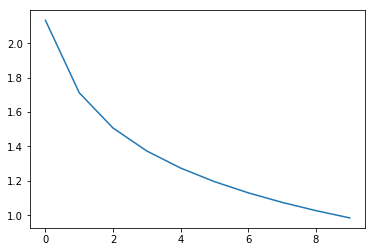

In [10]:
plt.plot(list(range(epochs)), loss)

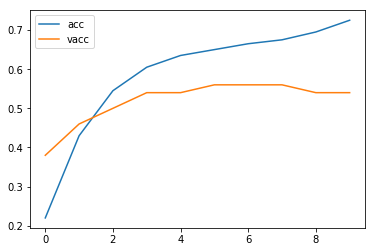

In [11]:
plt.plot(list(range(epochs)), acc, label='acc')
plt.plot(list(range(epochs)), vacc, label='vacc')
plt.legend()

In [ ]:
for i in range(W_conv.shape[0]):
    fig = plt.figure()
    plt.imshow(W_conv[i, :-1].reshape((7, 28))[:, :7].reshape(7, 7).T)
    plt.colorbar()
    plt.show()
    plt.close(fig)